In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import cv2

In [16]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 150

In [3]:
train_data = tfds.load("rock_paper_scissors", split="train", shuffle_files=True, as_supervised=True)

In [4]:
test_data = tfds.load("rock_paper_scissors", split="test", shuffle_files=True, as_supervised=True)

In [5]:
normalization_layer = layers.Rescaling(1./255)
resizing_layer = layers.Resizing(IMG_SIZE,IMG_SIZE)

normalized_train_data = train_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), y))
normalized_test_data = test_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), y))

In [30]:
img_input = layers.Input(shape=(150,150,3))

x = tf.image.rgb_to_grayscale(img_input)

x = layers.Conv2D(32, 3, activation="relu", kernel_regularizer="l2")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.LeakyReLU(0.01)(x)

x = layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.LeakyReLU(0.01)(x)

x = layers.Conv2D(128, 3, activation="relu", kernel_regularizer="l2")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.LeakyReLU(0.01)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu", activity_regularizer="l2")(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation="relu", activity_regularizer="l2")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(3, activation="softmax")(x)

model_2 = Model(img_input, output)

In [31]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.image.rgb_to_grayscale_2  (None, 150, 150, 1)      0         
  (TFOpLambda)                                                   
                                                                 
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 74, 74, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        1849

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint('./my_model.hdf5', save_best_only=True, save_weights_only=True, monitor='val_acc', mode='max')
model_checkpoint_2 = ModelCheckpoint('./my_model_2.hdf5', save_best_only=True, save_weights_only=True, monitor='val_acc', mode='max')
reduce_lr= ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["acc"])

In [9]:
! kaggle datasets download glushko/rock-paper-scissors-dataset

rock-paper-scissors-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
ext_train_data = tf.keras.utils.image_dataset_from_directory(".//train", class_names=["rock","paper","scissors"],shuffle=True, batch_size=None)
ext_train_data = ext_train_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), tf.cast(y,tf.int64)))
ext_test_data = tf.keras.utils.image_dataset_from_directory(".//test", class_names=["rock","paper","scissors"],shuffle=True, batch_size=batch_size)
ext_test_data = ext_test_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), tf.cast(y,tf.int64)))
ext_val_data = tf.keras.utils.image_dataset_from_directory(".//val", class_names=["rock","paper","scissors"],shuffle=True, batch_size=None)
ext_val_data = ext_val_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), tf.cast(y,tf.int64)))

Found 1020 files belonging to 3 classes.
Found 540 files belonging to 3 classes.
Found 804 files belonging to 3 classes.


In [21]:
def augment(dataset):
  model = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation((-0.2,0.2), fill_mode="nearest"),
      layers.RandomZoom((-0.2,0.2), fill_mode="nearest"),
      ])

  dataset = dataset.map(lambda x, y: (model(x, training=True), y),
              num_parallel_calls=AUTOTUNE)

  return dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
merged_train_data = normalized_train_data.concatenate(ext_train_data)
merged_val_data = normalized_test_data.concatenate(ext_val_data)

In [23]:
augmented_merged_train_data = augment(merged_train_data).concatenate(merged_train_data)

In [24]:
batched_merged_train_data = augmented_merged_train_data.batch(batch_size)
batched_merged_val_data = merged_val_data.batch(batch_size)

In [48]:
batched_train_data = augment(normalized_train_data).batch(batch_size)
batched_test_data = normalized_test_data.batch(batch_size)
batched_ext_train_data = augment(ext_train_data).batch(batch_size)
batched_ext_val_data = ext_val_data.batch(batch_size)

In [49]:
a = iter(augment(augmented_merged_train_data))

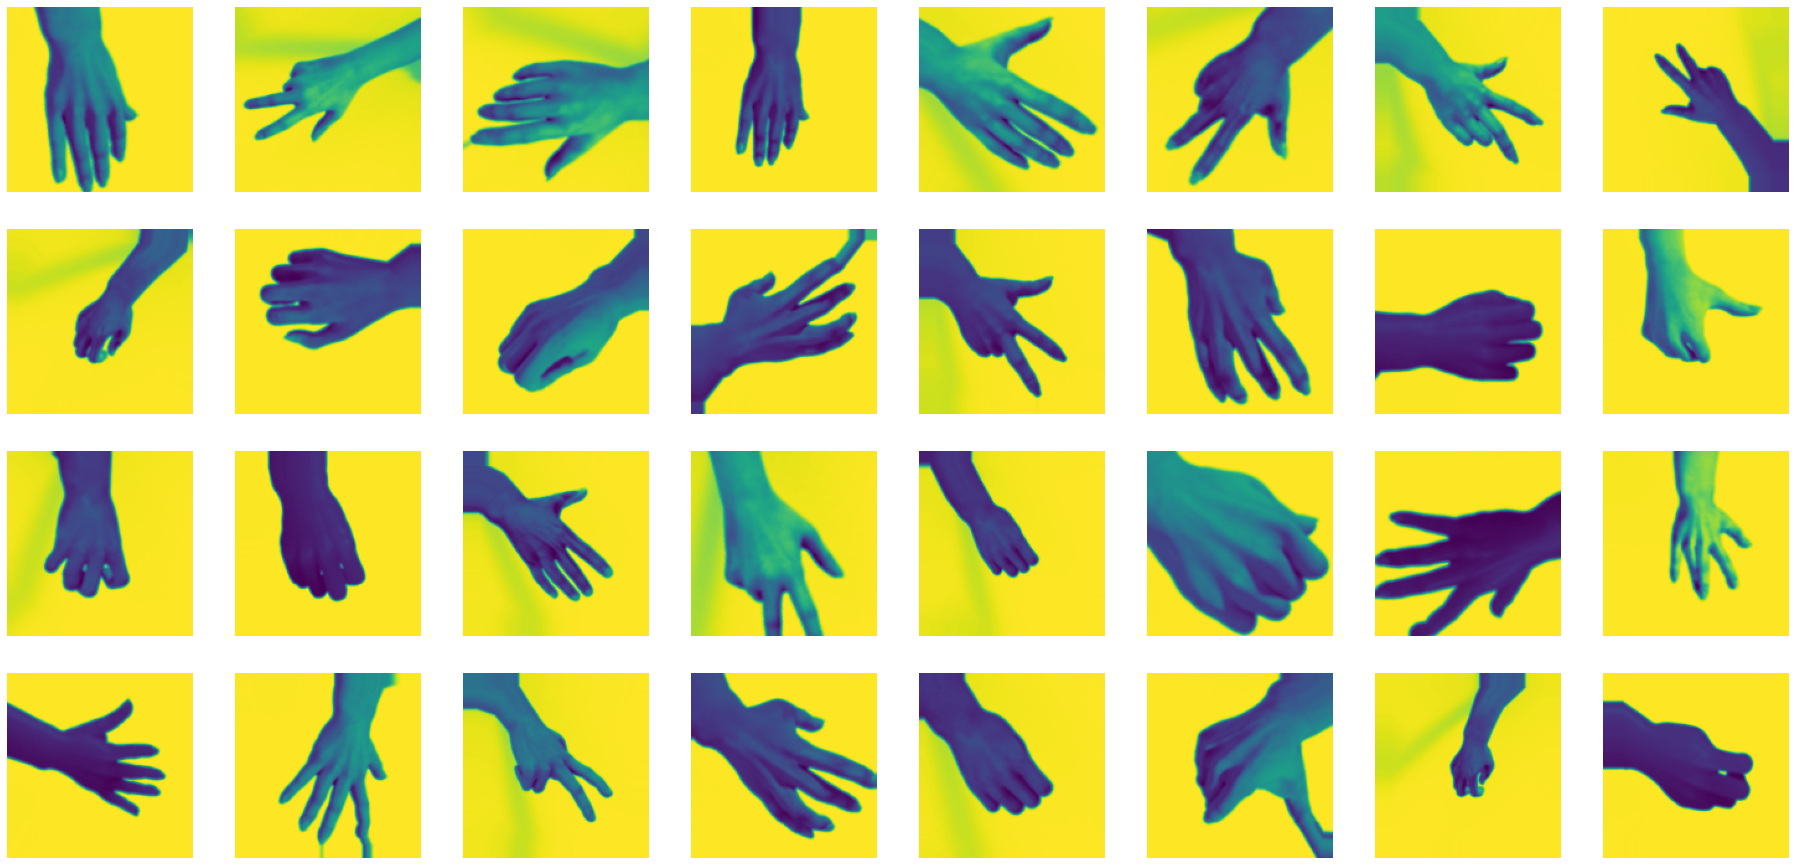

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(32, 32))
for i in range(32):
    plt.subplot(8, 8, i + 1)
    img = tf.image.rgb_to_grayscale(next(a)[0], cmap="gray")
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [33]:
history = model_2.fit(batched_merged_train_data.shuffle(buffer_size=10*batch_size),
                    epochs=20,
                    validation_data=batched_merged_val_data,
                    callbacks=[early_stopping, model_checkpoint_2, reduce_lr],
                    shuffle=True)

Epoch 1/20
222/222 [==============================] - 24s 59ms/step - loss: 1.0277 - acc: 0.6944 - val_loss: 1.0913 - val_acc: 0.5697 - lr: 0.0010
Epoch 2/20
222/222 [==============================] - 24s 58ms/step - loss: 0.4981 - acc: 0.8706 - val_loss: 1.1619 - val_acc: 0.5969 - lr: 0.0010
Epoch 3/20
222/222 [==============================] - 21s 57ms/step - loss: 0.3420 - acc: 0.9130 - val_loss: 1.0621 - val_acc: 0.6233 - lr: 0.0010
Epoch 4/20
222/222 [==============================] - 20s 56ms/step - loss: 0.2779 - acc: 0.9297 - val_loss: 0.9017 - val_acc: 0.6335 - lr: 0.0010
Epoch 5/20
222/222 [==============================] - 20s 55ms/step - loss: 0.2420 - acc: 0.9387 - val_loss: 1.0913 - val_acc: 0.6233 - lr: 0.0010
Epoch 6/20
222/222 [==============================] - 22s 58ms/step - loss: 0.2156 - acc: 0.9422 - val_loss: 1.0719 - val_acc: 0.6335 - lr: 0.0010
Epoch 7/20
222/222 [==============================] - 22s 57ms/step - loss: 0.1999 - acc: 0.9444 - val_loss: 0.9341 - 

Text(0.5, 1.0, 'Training and validation loss')

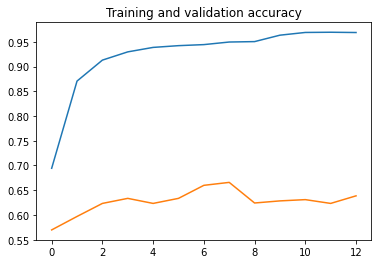

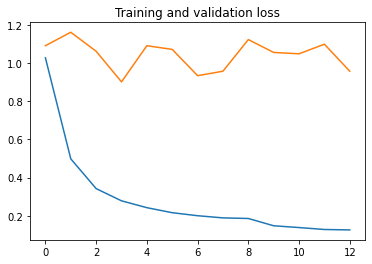

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [35]:
model_2.evaluate(ext_test_data)

34/34 [==============================] - 1s 23ms/step - loss: 1.6444 - acc: 0.4000


[1.6444472074508667, 0.4000000059604645]

In [73]:
cap = cv2.VideoCapture(0)
inp = None
while True:
    ret, frame = cap.read()
    cv2.imshow("frame",frame)
    if cv2.waitKey(1)==ord("e"):
        inp = frame
        break

cap.release()
cv2.destroyAllWindows()

pinp = tf.reshape(resizing_layer(normalization_layer(inp)), [1,IMG_SIZE,IMG_SIZE,3])
prediction = model_2.predict(pinp)
prediction.argmax()

1/1 [==============================] - 0s 43ms/step


0

In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [47]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False)

In [48]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [49]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [50]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', activity_regularizer="l2")(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['acc'])

In [51]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_15[0][0]']              
 rmalization)                                                                                     
                                                                                            

In [52]:
history = model.fit(batched_merged_train_data.shuffle(buffer_size=10*batch_size),
                    epochs=30,
                    validation_data=batched_merged_val_data,
                    callbacks=[early_stopping ,model_checkpoint, reduce_lr],
                    shuffle=True)

Epoch 1/30
222/222 [==============================] - 33s 85ms/step - loss: 0.5087 - acc: 0.9093 - val_loss: 0.6020 - val_acc: 0.7942 - lr: 1.0000e-04
Epoch 2/30
222/222 [==============================] - 27s 73ms/step - loss: 0.2826 - acc: 0.9733 - val_loss: 0.5815 - val_acc: 0.7985 - lr: 1.0000e-04
Epoch 3/30
222/222 [==============================] - 24s 69ms/step - loss: 0.2220 - acc: 0.9845 - val_loss: 0.5726 - val_acc: 0.7857 - lr: 1.0000e-04
Epoch 4/30
222/222 [==============================] - 24s 69ms/step - loss: 0.1945 - acc: 0.9850 - val_loss: 0.5110 - val_acc: 0.8257 - lr: 1.0000e-04
Epoch 5/30
222/222 [==============================] - 23s 70ms/step - loss: 0.1798 - acc: 0.9870 - val_loss: 0.4922 - val_acc: 0.8189 - lr: 1.0000e-04
Epoch 6/30
222/222 [==============================] - 25s 71ms/step - loss: 0.1672 - acc: 0.9857 - val_loss: 0.5042 - val_acc: 0.8333 - lr: 1.0000e-04
Epoch 7/30
222/222 [==============================] - 22s 67ms/step - loss: 0.1537 - acc: 0.99

In [53]:
model.evaluate(ext_test_data)

34/34 [==============================] - 3s 63ms/step - loss: 0.6767 - acc: 0.7333


[0.6766758561134338, 0.7333333492279053]

Text(0.5, 1.0, 'Training and validation loss')

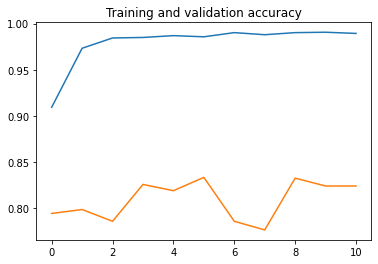

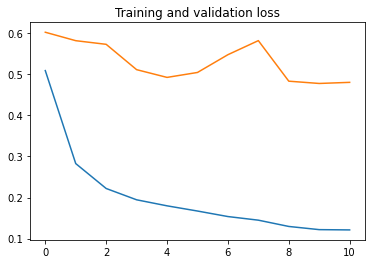

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [70]:
cap = cv2.VideoCapture(0)
inp = None
while True:
    ret, frame = cap.read()
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) == ord("e"):
        inp = frame
        break

cap.release()
cv2.destroyAllWindows()
pinp = tf.reshape(resizing_layer(normalization_layer(inp)), [1, IMG_SIZE, IMG_SIZE, 3])
prediction = model.predict(pinp)
prediction.argmax()

1/1 [==============================] - 0s 53ms/step


2

In [74]:
from keras.utils.vis_utils import plot_model

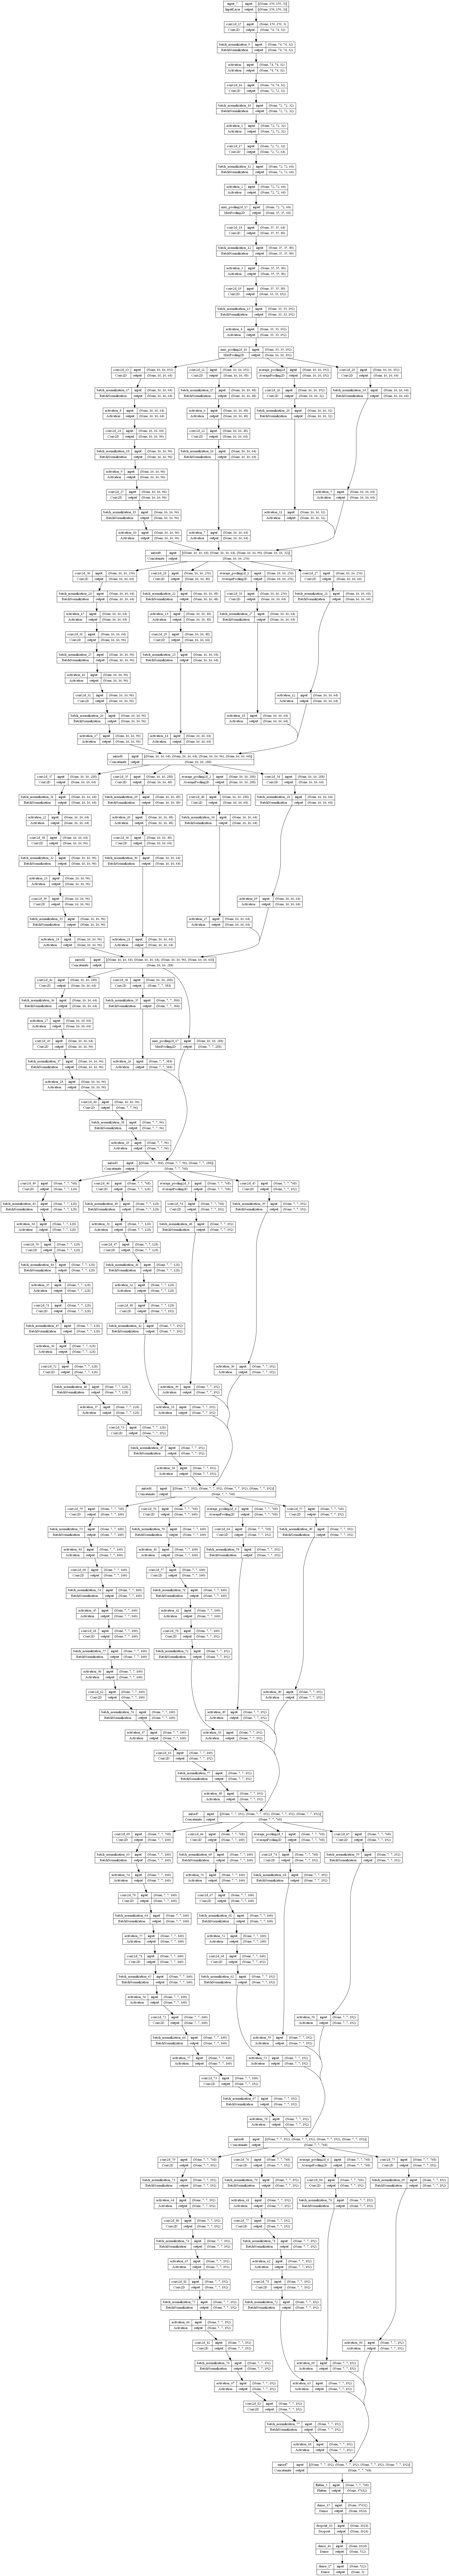

In [75]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

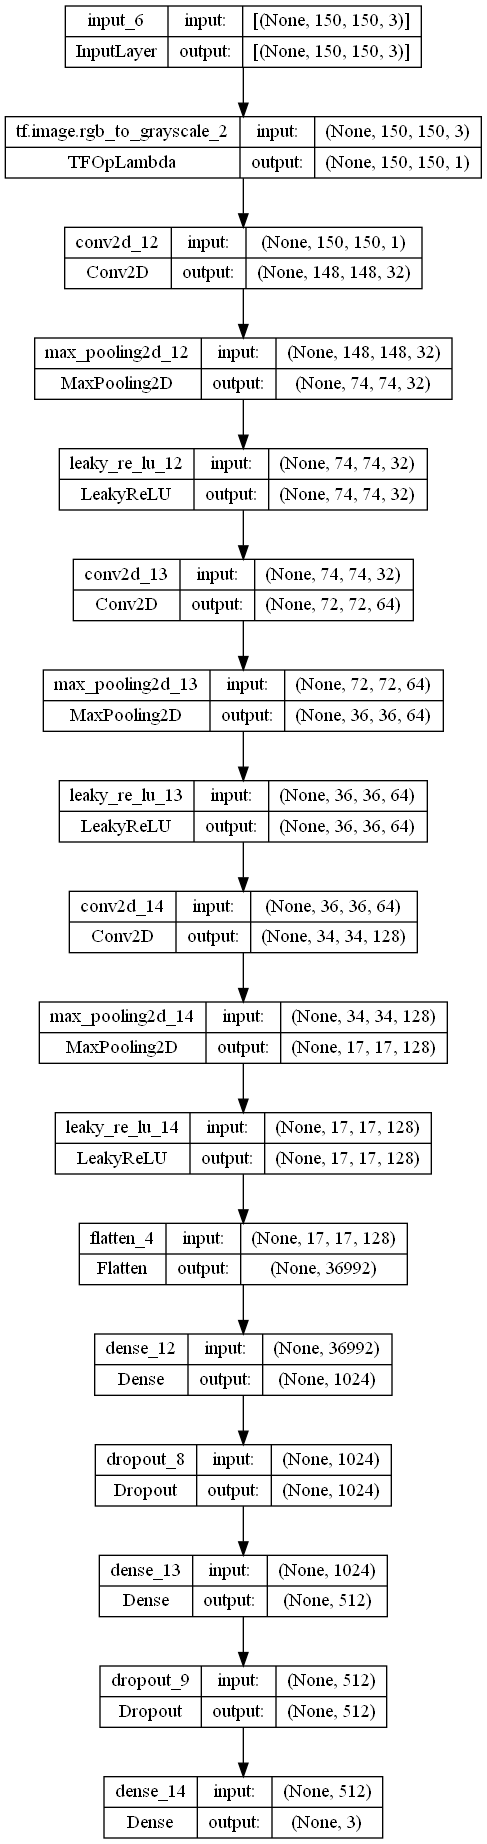

In [76]:
plot_model(model_2, to_file='model_plot_2.png', show_shapes=True, show_layer_names=True)